# Annotation Analysis

In this notebook, we will analyze the annotations generated by lay readers. First, we preprocess data for analysis, which is performed in three steps:

* We investigate the score attribute by the users to texts belonging to each category (_fact, opinion, entertainment, satire_ and _conspiracy_).
* We evaluate the answers to dichotomous questions (Yes vs. No), according to each category.
* Finally, we investigate the most influencing aspects that affect the credibility of an article according to the readers' viewpoint.

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import itertools

## Reading annotations from file.

In [2]:
df = pd.read_excel (r'../corpus/mint-annotations.xlsx')

# Droping unused columns.
df.drop(["Filename"], axis=1, inplace=True)

# Renaming columns to English short names.
df[:3]

,Category,Credibility,Accurate headline,Clickbait techniques,Irony in headline,Sentiment in headline,Sources of information,Sources credibility,Linguistic accuracy,Subjectivity,Sentiment intensity,Irony and sarcasm,Sensationalism,Personal attack,Appeal to fear,Influencing aspects
0,opinion,5,4,3,3,3,Não,NaN,4,Sim,4,Sim,3,Sim,Não,"apelo ao medo, representatividade do título, s..."
1,opinion,1,Não sei,Não sei,Não sei,Não sei,Não,NaN,Não sei,Não,Não sei,Não,Não sei,Não,Não,"ausência de fontes, correção linguística, menç..."
2,opinion,1,2,Não sei,5,5,Não,NaN,3,Sim,5,Sim,5,Sim,Sim,"apelo ao medo, ausência de fontes, manifestaçã..."


## Preparing data for analysis.

In [3]:
# Handling "Não sei" values.
df.replace(r'Não sei', np.NaN, regex=True, inplace=True)

# Handling answers to dichotomous questions.
df.replace(r'Não', False, regex=True, inplace=True)
df.replace(r'Sim', True, regex=True, inplace=True)

# Converting strings values to numeric values.
likert_columns = ["Credibility", "Accurate headline", "Clickbait techniques", "Irony in headline", "Sentiment in headline",
                  "Sources credibility", "Linguistic accuracy", "Sentiment intensity", "Sensationalism"]
df[likert_columns] = df[likert_columns].apply(pd.to_numeric)

# Spliting influencing aspects strings into list.
df["Influencing aspects"] = df["Influencing aspects"].str.split(", ", n=None)

df[:3]

,Category,Credibility,Accurate headline,Clickbait techniques,Irony in headline,Sentiment in headline,Sources of information,Sources credibility,Linguistic accuracy,Subjectivity,Sentiment intensity,Irony and sarcasm,Sensationalism,Personal attack,Appeal to fear,Influencing aspects
0,opinion,5.0,4.0,3.0,3.0,3.0,False,NaN,4.0,True,4.0,True,3.0,True,False,"[apelo ao medo, representatividade do título, ..."
1,opinion,1.0,NaN,NaN,NaN,NaN,False,NaN,NaN,False,NaN,False,NaN,False,False,"[ausência de fontes, correção linguística, men..."
2,opinion,1.0,2.0,NaN,5.0,5.0,False,NaN,3.0,True,5.0,True,5.0,True,True,"[apelo ao medo, ausência de fontes, manifestaç..."


## Counting answers by category.

In [4]:
df.groupby('Category').size().reset_index(name='counts')

,Category,counts
0,conspiracy,137
1,entertainment,154
2,fact,156
3,opinion,153
4,satire,150


## Handling answers to likert-scale questions.

In [5]:
df_likert = df.filter(["Category"]+likert_columns , axis=1)
df_mean_likert = df_likert.groupby('Category').mean()
df_mean_likert

,Credibility,Accurate headline,Clickbait techniques,Irony in headline,Sentiment in headline,Sources credibility,Linguistic accuracy,Sentiment intensity,Sensationalism
Category,,,,,,,,,
conspiracy,1.932836,2.576642,3.864000,3.253731,3.445255,3.098039,2.573529,3.715328,4.229630
entertainment,3.062500,3.326667,3.765957,2.424658,3.439189,3.437500,3.238411,3.464052,3.700000
fact,3.568627,3.445161,3.067568,2.118421,3.025806,3.798077,3.721854,2.805195,2.870130
opinion,2.644295,2.979730,3.289855,3.395973,3.574324,3.500000,3.228188,3.800000,3.483221
satire,1.362416,2.852349,3.554745,4.067114,2.767123,2.217391,2.473333,3.140940,4.108844


### Plotting bar chart to likert-scale questions.

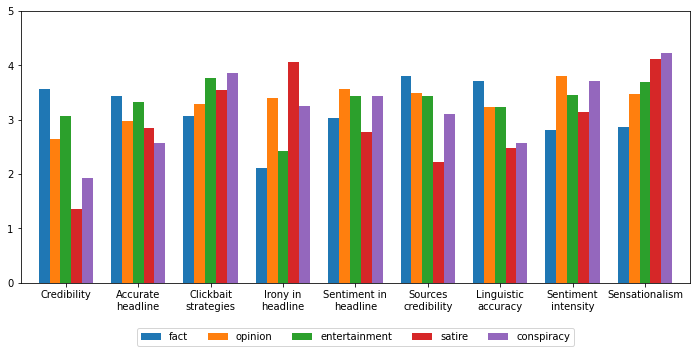

In [6]:
index_likert = ["Credibility", "Accurate\nheadline", "Clickbait\nstrategies", "Irony in\nheadline", "Sentiment in\nheadline",
         "Sources\ncredibility", "Linguistic\naccuracy", "Sentiment\nintensity", "Sensationalism"]

df_mean_likert_T = df_mean_likert.T.reindex(columns=['fact','opinion','entertainment','satire','conspiracy'])

fig, ax = plt.subplots()
df_mean_likert_T.plot(kind="bar", width=0.75, figsize=(12,5), ax=ax)
plt.legend(loc='lower center', bbox_to_anchor=(0., -0.25, 1, 0.), ncol=5)
plt.xticks(rotation=0)
plt.ylim((0, 5.0))
ax.set_xticklabels(index_likert)
plt.show()

## Handling answers to dichotomous questions.

In [7]:
dichotomous_columns = ["Sources of information", "Subjectivity", "Irony and sarcasm", "Personal attack", "Appeal to fear"]

df_dich = df.filter(["Category"]+dichotomous_columns , axis=1)
df_dich

# Percentage of answer Yes in dichotomous questions.
df_dict_true = df_dich.set_index('Category').astype(bool).groupby(level=0).mean()
df_dict_true

,Sources of information,Subjectivity,Irony and sarcasm,Personal attack,Appeal to fear
Category,,,,,
conspiracy,0.386861,0.802920,0.729927,0.817518,0.715328
entertainment,0.435065,0.454545,0.318182,0.415584,0.207792
fact,0.679487,0.256410,0.217949,0.365385,0.243590
opinion,0.228758,0.869281,0.666667,0.705882,0.490196
satire,0.166667,0.473333,0.906667,0.633333,0.240000


### Plotting bar chart to dichotomous questions.

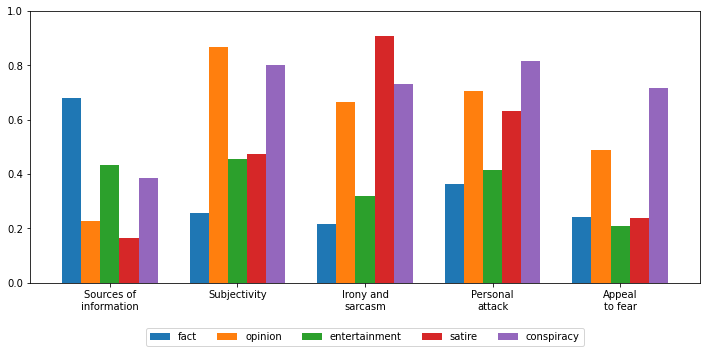

In [8]:
index_dich = ["Sources of\ninformation", "Subjectivity", "Irony and\nsarcasm", "Personal\nattack", "Appeal\nto fear"]

df_dict_true_T = df_dict_true.T.reindex(columns=['fact','opinion','entertainment','satire','conspiracy'])

fig, ax = plt.subplots()
df_dict_true_T.plot(kind="bar", width=0.75, figsize=(12,5), ax=ax)
plt.legend(loc='lower center', bbox_to_anchor=(0., -0.25, 1, 0.), ncol=5)
plt.xticks(rotation=0)
plt.ylim((0, 1.0))
ax.set_xticklabels(index_dich)
plt.show()

## Investigating the influencing aspects to challenge a text's credibility according to readers.

In [9]:
all_aspects = list(itertools.chain.from_iterable(df["Influencing aspects"].values.tolist()))
counts = Counter(all_aspects)
df_aspects_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_aspects_counts = df_aspects_counts.rename(columns={"index": "aspects", 0:'values'})

df_aspects_counts["values"] = df_aspects_counts["values"]/df_aspects_counts["values"].sum()
df_aspects_counts.sort_values('values', ascending=False, inplace=True)
df_aspects_counts

,aspects,values
3,ausência de fontes,0.212219
0,apelo ao medo,0.110243
7,ataque contra indivíduos ou organizações,0.109325
2,sensacionalismo da notícia,0.106569
4,correção linguística,0.092329
5,menção a fontes pouco credíveis,0.084979
10,utilização de técnicas de clickbait,0.084061
8,manifestação de opinião,0.072118
9,uso de ironia e sarcasmo,0.055581
6,manifestação de sentimento ou emoção,0.055122


### Plotting bar chart of most important credibility aspects indicated by readers.

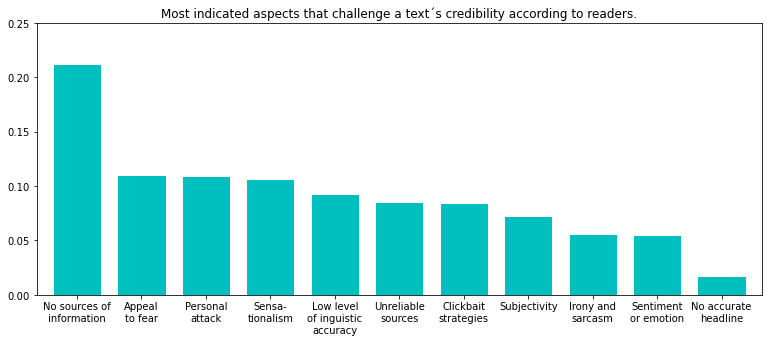

In [10]:
index_aspects = ["No sources of\ninformation", "Appeal\nto fear", "Personal\nattack", "Sensa-\ntionalism",  
                 "Low level\nof inguistic\naccuracy", "Unreliable\nsources", "Clickbait\nstrategies", "Subjectivity",
                 "Irony and\nsarcasm", "Sentiment\nor emotion", "No accurate\nheadline"]

 
fig, ax = plt.subplots()
df_aspects_counts.plot(y="values", kind="bar",  figsize=(13,5), width=0.75, color=['c'], edgecolor='w', legend=None, ax=ax)
plt.xticks(rotation=0)
plt.ylim((0, 0.25))
plt.title('Most indicated aspects that challenge a text´s credibility according to readers.')
ax.set_xticklabels(index_aspects)
plt.show()